
<a href="https://colab.research.google.com/github/takzen/ai-engineering-handbook/blob/main/notebooks/049_Object_Detection_IoU.ipynb" target="_parent">
    <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>



<a href="https://colab.research.google.com/github/takzen/ai-engineering-handbook/blob/main/49_Object_Detection_IoU.ipynb" target="_parent">
    <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


# 🎯 IoU: Matematyka Wykrywania Obiektów

W klasyfikacji sprawa jest prosta: wynik to 0 lub 1.
W detekcji obiektów wynik to **4 liczby** (współrzędne ramki: x1, y1, x2, y2).

Jak sprawdzić, czy model trafił?
Używamy metryki **IoU (Intersection over Union)**.

$$ IoU = \frac{\text{Obszar Przecięcia (Intersection)}}{\text{Obszar Sumy (Union)}} $$

*   **IoU = 1.0:** Ramki pokrywają się idealnie.
*   **IoU = 0.0:** Ramki się nie dotykają.
*   **IoU > 0.5:** Zazwyczaj uznajemy to za "Dobre trafienie" (Good detection).

W tym notatniku napiszemy funkcję IoU od zera i zwizualizujemy ją.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

# Definiujemy dwie ramki (Format: [x1, y1, x2, y2])
# x1, y1 = lewy górny róg
# x2, y2 = prawy dolny róg

# Ramka Prawdziwa (Ground Truth) - Zielona
box_true = [50, 50, 200, 200] 

# Ramka Przewidziana przez AI (Prediction) - Czerwona
# Trochę przesunięta w prawo i w dół
box_pred = [100, 100, 220, 230]

print(f"Prawda: {box_true}")
print(f"Predykcja: {box_pred}")

Prawda: [50, 50, 200, 200]
Predykcja: [100, 100, 220, 230]


## Matematyka Przecięcia (Intersection)

To jest najtrudniejsza część logiczna. Jak znaleźć prostokąt, który jest częścią wspólną?

1.  **Lewa krawędź:** To maksimum z lewych krawędzi obu ramek (`max(x1_a, x1_b)`).
2.  **Górna krawędź:** To maksimum z górnych krawędzi.
3.  **Prawa krawędź:** To minimum z prawych krawędzi.
4.  **Dolna krawędź:** To minimum z dolnych krawędzi.

Jeśli "Prawa" jest mniejsza niż "Lewa" -> Brak przecięcia (Area = 0).

In [2]:
def calculate_iou(boxA, boxB):
    # 1. Obliczamy współrzędne prostokąta przecięcia (Intersection)
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # 2. Obliczamy pole powierzchni przecięcia
    # max(0, ...) jest potrzebne, bo jeśli ramki się nie stykają, różnica będzie ujemna
    interWidth = max(0, xB - xA)
    interHeight = max(0, yB - yA)
    interArea = interWidth * interHeight

    # 3. Obliczamy pola powierzchni obu ramek osobno
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])

    # 4. Obliczamy sumę (Union)
    # Wzór: Pole A + Pole B - Część Wspólna (żeby nie liczyć jej podwójnie)
    unionArea = boxAArea + boxBArea - interArea

    # Zabezpieczenie przed dzieleniem przez zero
    if unionArea == 0: return 0

    # 5. Wynik IoU
    iou = interArea / unionArea
    return iou

# Sprawdźmy nasz wynik
iou_score = calculate_iou(box_true, box_pred)
print(f"Wynik IoU: {iou_score:.4f}")

Wynik IoU: 0.3559


## Wizualizacja

Narysujmy to, żeby zobaczyć, czy matematyka zgadza się z rzeczywistością.

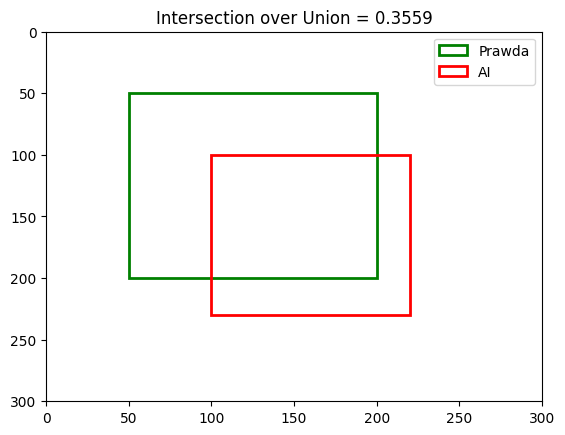

In [3]:
def plot_boxes(boxA, boxB, iou):
    fig, ax = plt.subplots(1)
    
    # Ustawiamy rozmiar płótna
    ax.set_xlim(0, 300)
    ax.set_ylim(300, 0) # Odwracamy oś Y (bo w obrazkach 0 jest na górze)
    
    # Rysujemy Prawdę (Zielony)
    # Matplotlib chce (x, y, width, height), my mamy (x1, y1, x2, y2)
    rectA = patches.Rectangle((boxA[0], boxA[1]), boxA[2]-boxA[0], boxA[3]-boxA[1], 
                              linewidth=2, edgecolor='g', facecolor='none', label='Prawda')
    
    # Rysujemy Predykcję (Czerwony)
    rectB = patches.Rectangle((boxB[0], boxB[1]), boxB[2]-boxB[0], boxB[3]-boxB[1], 
                              linewidth=2, edgecolor='r', facecolor='none', label='AI')
    
    ax.add_patch(rectA)
    ax.add_patch(rectB)
    
    plt.legend()
    plt.title(f"Intersection over Union = {iou:.4f}")
    plt.show()

plot_boxes(box_true, box_pred, iou_score)

In [4]:
# TESTY SKRAJNE
print("--- TESTY ---")

# 1. Idealne trafienie
box_perfect = [50, 50, 200, 200]
print(f"Idealne trafienie: {calculate_iou(box_true, box_perfect):.2f} (Oczekiwane: 1.00)")

# 2. Brak styku
box_far = [250, 250, 300, 300]
print(f"Brak styku:       {calculate_iou(box_true, box_far):.2f} (Oczekiwane: 0.00)")

# 3. Mały kawałek
box_small = [190, 190, 250, 250]
print(f"Mały styk:        {calculate_iou(box_true, box_small):.4f}")

--- TESTY ---
Idealne trafienie: 1.00 (Oczekiwane: 1.00)
Brak styku:       0.00 (Oczekiwane: 0.00)
Mały styk:        0.0038


## 🧠 Podsumowanie: Jak działa Tesla?

Dokładnie ten kod (tylko zoptymalizowany w C++) działa w samochodach autonomicznych tysiące razy na sekundę.

Samochód widzi innego pieszego. Sieć YOLO wypluwa 100 ramek wokół tego pieszego.
1.  Samochód liczy IoU między tymi ramkami.
2.  Jeśli ramki mają IoU > 0.9 (pokrywają się prawie idealnie), to znaczy, że to **ten sam pieszy**, a nie 5 różnych.
3.  Używa algorytmu **NMS (Non-Max Suppression)**, żeby zostawić tylko jedną, najlepszą ramkę, a resztę (duplikaty) wyrzucić.

Bez matematyki IoU systemy wizyjne widziałyby duchy i duplikaty obiektów.